In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time, sys
import random
import pickle
from tqdm import tqdm 

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
rank = 30
mtype = "gics_hodlr"


with open('../../data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

with open("../../data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       hpart = pickle.load(f)

Z = mf.demean_clip(C)
A = Z @ Z.T / (Z.shape[1]-1)

# permute rows and cols to place partitions on the diagonal
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]

m = n = A.shape[0]

symm = np.allclose(A, A.T) if m==n else False
if symm:
       print(f"MLR storage = {rank * m}")
else:
       print(f"MLR storage = {rank * (m + n)}")

mlr_storage = rank * (m + n)

MLR storage = 150000


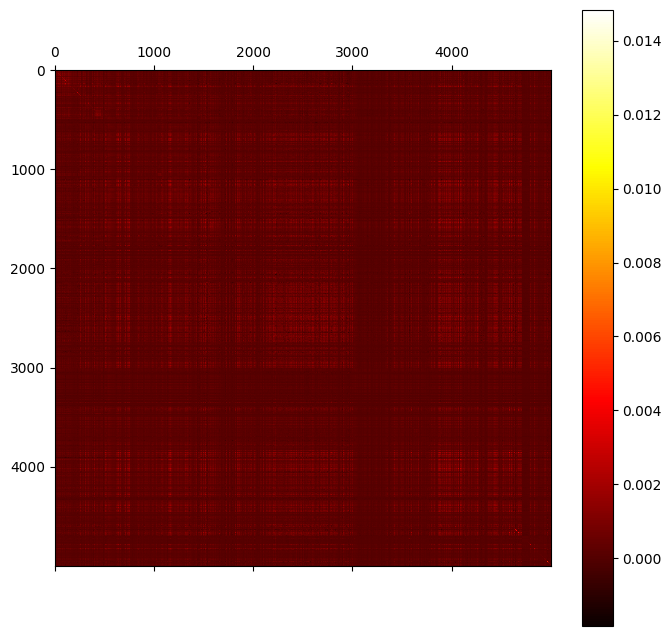

In [4]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(perm_A, cmap='hot')
fig.colorbar(cax)
plt.show()

In [5]:
assert m == hpart['rows']['pi'].size and n == hpart['cols']['pi'].size
for level in range(len(hpart['rows']['lk'])):
    avg_rows = np.diff(np.array(hpart['rows']['lk'][level])).mean()
    avg_cols = np.diff(np.array(hpart['cols']['lk'][level])).mean()
    print(f"{level=}, {hpart['rows']['lk'][level].size-1}, {avg_rows=}, {avg_cols=}")

level=0, 1, avg_rows=5000.0, avg_cols=5000.0
level=1, 11, avg_rows=454.54545454545456, avg_cols=454.54545454545456
level=2, 24, avg_rows=208.33333333333334, avg_cols=208.33333333333334
level=3, 69, avg_rows=72.46376811594203, avg_cols=72.46376811594203
level=4, 157, avg_rows=31.84713375796178, avg_cols=31.84713375796178
level=5, 5000, avg_rows=1.0, avg_cols=1.0


In [6]:
rel_tol = 0.0321875
tol = rel_tol * np.linalg.norm(A, ord='fro')
tol

0.060459025975688675

In [7]:
A_HODLR, A_HODLR_fillin, bl_sizes, count = mf.build_hodlr(hpart, m, n, A, tol)

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


In [8]:
np.histogram(A_HODLR_fillin.reshape(-1), bins=5)

(array([       0,        0, 25000000,        0,        0]),
 array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]))

In [9]:
hodlr_storage = mf.get_hodlr_storage(bl_sizes, count, m, n)

In [10]:
np.histogram(bl_sizes[:, 0])

(array([15390,     0,     0,     2,     0,     0,     2,     0,     0,
            2]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]))

In [11]:
print(f"{rel_tol=},   err={mf.rel_diff(A_HODLR, den=A)},   {hodlr_storage=}")
# rel_tol=0.08,   err=0.605652777206689,       hodlr_storage=53506
# rel_tol=0.05,   err=0.4673926939625523,      hodlr_storage=82620
# rel_tol=0.035,   err=0.39538711927050957,    hodlr_storage=217034 
# rel_tol=0.033125,   err=0.39172570208165686, hodlr_storage=267418
# rel_tol=0.0321875,   err=0.38837333755529285,hodlr_storage=300602
# rel_tol=0.03125,   err=0.38246816032790387,  hodlr_storage=337402
# rel_tol=0.0275,   err=0.3701862071812824,    hodlr_storage=514324
# rel_tol=0.02,     err=0.33890080279264706,   hodlr_storage=1230078
# rel_tol=0.0125,   err=0.30156983884529476,   hodlr_storage=2994482
# rel_tol=0.012375,   err=0.29950498092290145,   hodlr_storage=3046196
# rel_tol=0.01225,   err=0.2980456938751135,   hodlr_storage=3101112
# rel_tol=0.012,   err=0.2964736230506155,     hodlr_storage=3206532
# rel_tol=0.0104,   err=0.27624893696563635,   hodlr_storage=3949970
# rel_tol=0.009,   err=0.25451741823240703,    hodlr_storage=4802042
# rel_tol=0.005,   err=0.17557936959492396,    hodlr_storage=8718154

rel_tol=0.0321875,   err=0.38837333755529285,   hodlr_storage=300602


In [12]:
(0.03125+0.033125)/2

0.0321875

In [13]:
print(f"{hodlr_storage/2.=}")
print(f"  {mlr_storage/2.=}")
print(f"       {m * n =}")
print(f"{m*n - hodlr_storage=}")
mlr_storage * 1./ hodlr_storage

hodlr_storage/2.=150301.0
  mlr_storage/2.=150000.0
       m * n =25000000
m*n - hodlr_storage=24699398


0.9979973519803594

In [14]:
# LR             0.16178478761767232
# LR+D           0.1537922868665804
# MLR uniform    0.15379228615265847
# MLR bottom     0.15379228605054865
# MLR top        0.15379228616060095

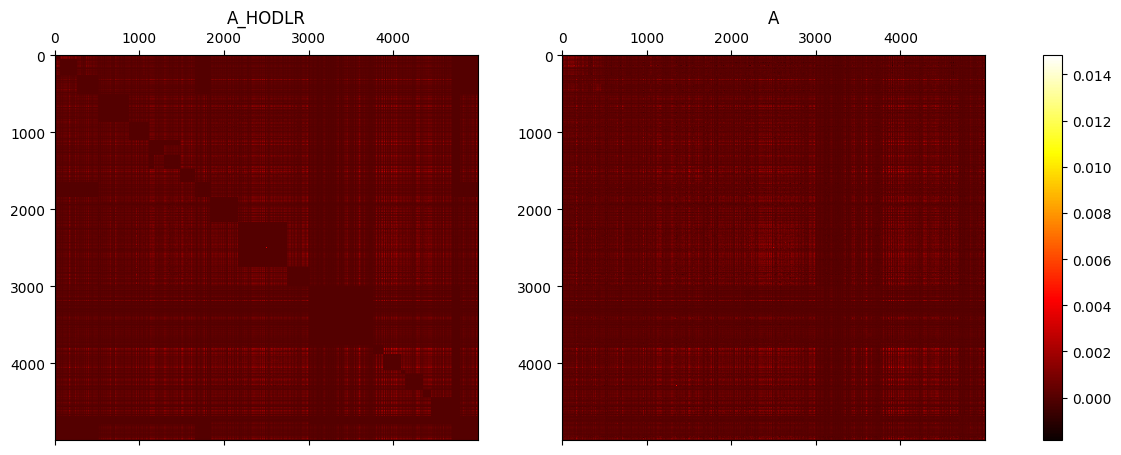

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_HODLR.min())
vmax = max(A.max(), A_HODLR.max())

cax1 = axs[0].matshow(A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_HODLR')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A, cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()

In [16]:
np.allclose(np.diag(A), np.diag(A_HODLR))

True